### Edgar Moises Hernandez-Gonzalez
#### 27/07/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-2D + LSTM
##### Caracteristicas = Escalogramas CWT (3D)
##### Entrada resize proporcional de 90x384
##### 5 ejecuciones independientes

In [2]:
from google.colab import drive

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pywt
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [9]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [4]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv", header=None).iloc[:, 0:768]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv", header=None).iloc[:, 1536:2304]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv", header=None).iloc[:, 0:768]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv", header=None).iloc[:, 1536:2304]

In [5]:
x_train = pd.concat([c3_train, c4_train], axis=1)
x_test = pd.concat([c3_test, c4_test], axis=1)

In [6]:
# x_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_train.csv", header=None)
# x_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/MIEEG_test.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/etiquetas_train.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-II-III/Datos/etiquetas_test.csv", header=None)

In [8]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(140, 1536)
(140, 1536)
(140, 1)
(140, 1)


In [10]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples_train = len(y_train)
n_samples_test = len(y_test)

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 140
n_samples_test : 140


In [11]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [12]:
#unir 2 canales y 3 segundos
def unir_escalogramas_vertical(data):
  fs = 128
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  datos = np.zeros((data.shape[0],90,384))
  temporal = np.zeros((90,384))
  for i in range(data.shape[0]): #n muestras
    for j in range(2): #2 canales
      sig = data.iloc[i, j*768:(j+1)*768]
      sig = sig[32:416]
      # escalograma CWT
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3', sampling_period = (1 / fs))
      temporal[j*45:(j+1)*45, :] = abs(coef)
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [13]:
#llamar a unir_escalogramas_vertical(data)
inicio = time.time()

x_train = unir_escalogramas_vertical(x_train)
x_test = unir_escalogramas_vertical(x_test)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
0
100
Tiempo: 4.9609479904174805


In [14]:
print(x_train.shape)
print(x_test.shape)

(140, 90, 384)
(140, 90, 384)


In [15]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.3294700378598465
0.341911306993214
5.1099372270130575e-06
4.934162308476574e-06
0.01759235428269688
0.018169201711793974


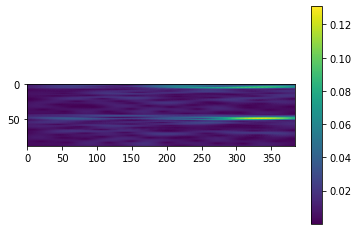

In [16]:
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

In [17]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(140, 1, 90, 384, 1)
(140, 1, 90, 384, 1)


In [18]:
mc = ModelCheckpoint('/content/drive/My Drive/BCI-II-III/Modelos/CWT_RNN.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=0)

In [19]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(16, activation='tanh', dropout=0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.5009295157023839
accuracy:  0.7571428418159485
confusion matrix:
 [[52 18]
 [16 54]]


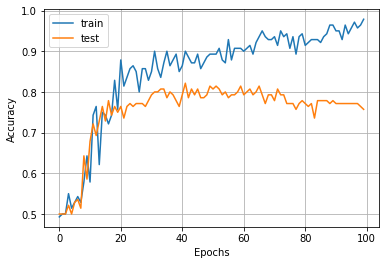

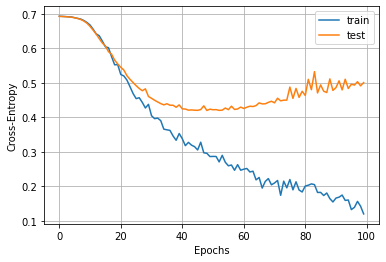

Iteration: 2
loss:  0.5051856441157204
accuracy:  0.7928571701049805
confusion matrix:
 [[53 17]
 [12 58]]


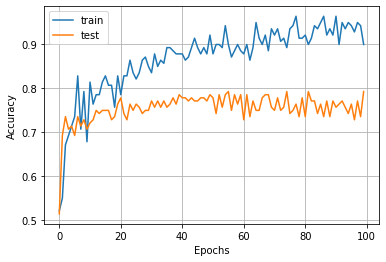

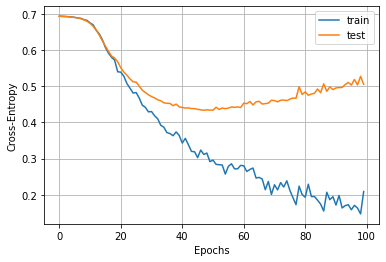

Iteration: 3
loss:  0.5600665662969861
accuracy:  0.75
confusion matrix:
 [[53 17]
 [18 52]]


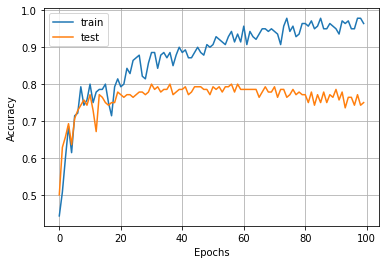

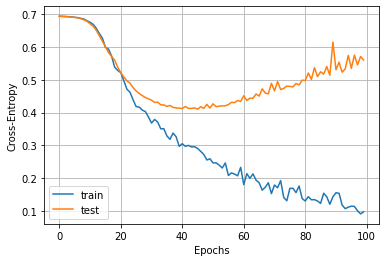

Iteration: 4
loss:  0.47099310840879166
accuracy:  0.7857142686843872
confusion matrix:
 [[59 11]
 [19 51]]


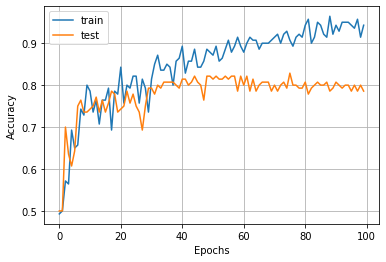

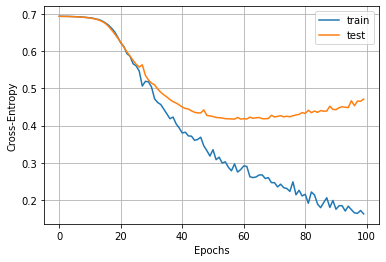

Iteration: 5
loss:  0.47334074633462087
accuracy:  0.7642857432365417
confusion matrix:
 [[55 15]
 [18 52]]


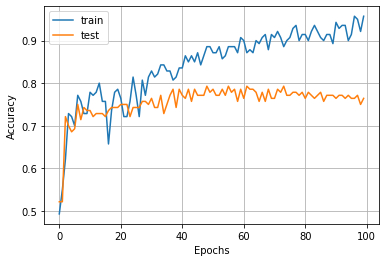

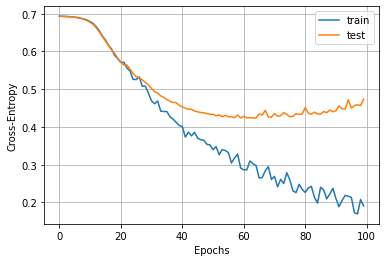


Resultados:
loss: [0.5009295157023839, 0.5051856441157204, 0.5600665662969861, 0.47099310840879166, 0.47334074633462087]
accuracy: [0.7571428418159485, 0.7928571701049805, 0.75, 0.7857142686843872, 0.7642857432365417]
Tiempo: 136.96947145462036


In [21]:
inicio = time.time()
array_loss = []
array_acc = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D_LSTM_TD()

  history = model.fit(x_train, y_train, epochs=100, batch_size=16,
                      validation_data=(x_test, y_test), verbose=0,
                      callbacks=[mc])
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [22]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 1, 90, 384, 8)     80        
_________________________________________________________________
time_distributed_22 (TimeDis (None, 1, 45, 192, 8)     0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 1, 45, 192, 8)     584       
_________________________________________________________________
time_distributed_24 (TimeDis (None, 1, 22, 96, 8)      0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 1, 16896)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                1082432   
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [23]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.7700
std: (+/- 0.0165)
Max Accuracy: 0.7929
Tiempo: 136


In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jul 27 05:22:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    73W / 149W |    745MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------